## Nonlinear pulse propagation

From Hamerly's paper.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time
import scipy

#The following hack is for importing a module from the "Modules" folder
import os
cwd = os.getcwd()
os.chdir('..')
from Modules.analysis import FTX, IFTX
os.chdir(cwd)

## Units
We'll work in the following units:

time = ps <br>
frequency = THz (1/time) <br>
distance = mm

In [3]:
from scipy.constants import pi, c
c = c*1e-9; #mm/ps, [Freq]=THz

## Single Pass

In [4]:
def single_pass(a,b,Da,Db,epsilon,L,h,plot=False):
    zi = 0
    
    if plot==True:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion()
        fig.canvas.draw()
        
    while zi<L:
        #Linear half step (front)
        A = np.fft.fft(a)
        A = A*Da
        a = np.fft.ifft(A)
        B = np.fft.fft(b)
        B = B*Db
        b = np.fft.ifft(B)
        
        #Nonlinear step
        #Runge-Kutta for a
        k1 = h/2*epsilon*b*np.conj(a)
        k2 = h/2*epsilon*b*np.conj(a+k1/2)
        k3 = h/2*epsilon*b*np.conj(a+k2/2)
        k4 = h/2*epsilon*b*np.conj(a+k3)
        a = a + (1/6)*(k1+2*k2+2*k3+k4)

        #Integral for b
        b = b - 0.5*h*epsilon*a*a
        
        #Runge-Kutta for a
        k1 = h/2*epsilon*b*np.conj(a)
        k2 = h/2*epsilon*b*np.conj(a+k1/2)
        k3 = h/2*epsilon*b*np.conj(a+k2/2)
        k4 = h/2*epsilon*b*np.conj(a+k3)
        a = a + (1/6)*(k1+2*k2+2*k3+k4)
        
        #Linear half step (back)
        A = np.fft.fft(a)
        A = A*Da
        a = np.fft.ifft(A)
        B = np.fft.fft(b)
        B = B*Db
        b = np.fft.ifft(B)
        
        #Next z
        zi = zi+h

        if plot==True and zi%2<0.1:
            ax.clear()
            ax.plot(t, abs(a), t, abs(b));
            ax.axes.set_ylim(0,2000)
            fig.canvas.draw()
            time.sleep(0.001)

    return a,b

## OPO

In [5]:
def opo(L=40, alpha = 0.00691,  u = 0.329, Tp = 13.2, b2a = 1.12e-4, 
        b3a = 3.09e-5, b2b = 4.06e-4, b3b = 2.51e-5, epsilon = 5.16e-5,
       G0 = 2.5, b0 = 3.84e2, p = 1.1, phi0=0, h=0.1, plot=False):
    
    #Initialize signal
    a = np.random.normal(0,1e-3,1024)
    a_prev = a

    #Linear operators
    Da = np.exp((-alpha/2 + 1j*b2a*Omega**2/2 - 1j*b3a*Omega**3/6)*h/2)
    Db = np.exp((-alpha/2 - 1j*u*Omega + 1j*b2b*Omega**2/2 - 1j*b3b*Omega**3/6)*h/2)
    
    #Feedback response
    fb = np.sqrt(1/G0)*np.exp(1j*phi0)
    
    N = 5000 #Max number of loops

    #Initialize convergence testing vector
    Vdiff = np.zeros((N,1))
    
    if plot==True:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion()
        fig.canvas.draw()
    
    for kn in range(N):
        b = b0*p*b_shape
        a,b = single_pass(a,b,Da,Db,epsilon,L,h)

        #Power calc
        Pa = scipy.integrate.simps(np.abs(a)**2,t)

        #Check if steady state at output of section
        Pdiff = scipy.integrate.simps((np.abs(a_prev - a)**2),t)
        diff = Pdiff/Pa*100
        Vdiff[kn] = diff
        a_prev = a
        if diff<1e-3:
            break
            
        #Apply feedback
        a = a*fb
        
        if plot==True:
            ax.clear()
            ax.plot(t, abs(a), t, abs(b));
            ax.axes.set_ylim(0,2000)
            ax.text(40,1400,'N=' + str(kn))
            ax.text(40,1200,'Pa=' + str(round(Pa*1e-8,3)))
            ax.text(40,1000,'diff=' + str(round(diff,3)))
            fig.canvas.draw()
            time.sleep(0.001)
        
    return a, Pa

# Tests

## Input parameters

In [6]:
#Input parameters
la = 1.5 #um
lb = la/2 #um
L = 40 #mm
alpha = 0.00691 #1/mm
u = 0.329 #ps/mm
Tp = 13.2 #ps
b2a = 1.12e-4 #ps^2/mm
b3a = 3.09e-5 #ps^3/mm
b2b = 4.06e-4
b3b = 2.51e-5
epsilon = 5.16e-5 #ps^0.5/mm
G0 = 3.33
b0 = 3.84e2 #ps^0.5 !?

p = 1.1 #normalized power
l = 0 #detuning

phi0 = pi*l

## Time and Frequency domain windows

In [7]:
#Simulation window setup
N = 1024 #Fourier size

#Let's base the window size on the pump duration
xtra = 4
t = np.linspace(-xtra*Tp, xtra*Tp, N)
ts = t[1]-t[0] #Sampling period
print('Sampling Rate =',ts, 'ps')

#Frequency domain
Omega = 2*pi*np.fft.fftfreq(t.size, ts) #Angular frequencies
print('Freq max =', np.amax(Omega), 'THz')

Sampling Rate = 0.10322580645161139 ps
Freq max = 30.374737076120997 THz


## Pump pulse shape

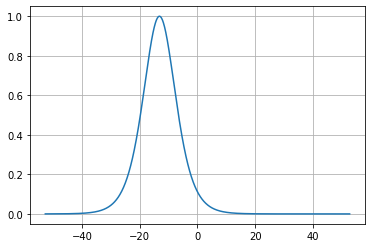

In [8]:
t0 = -Tp
tau = Tp/1.76
b_shape = 1/np.cosh((t-t0)/tau)**2

fig = plt.figure()
ax = fig.add_subplot(111)
fig.canvas.draw()
ax.clear()
ax.plot(t,b_shape)
ax.grid()
fig.canvas.draw()

## Single Pass Test

h = 0.1 #Distance step Size

#Linear operators
Da = np.exp((-alpha/2 + 1j*b2a*Omega**2/2 - 1j*b3a*Omega**3/6)*h/2)
Db = np.exp((-alpha/2 - 1j*u*Omega + 1j*b2b*Omega**2/2 - 1j*b3b*Omega**3/6)*h/2)

a = 500*b_shape
# a = np.random.normal(0,1e-3,1024)
b = b0*p*b_shape
a,b = single_pass(a,b,Da,Db,epsilon,L,h,plot=True)

## OPO Test

a, Pa = opo(phi0=0, p=1.5, h=0.2, plot=True)

A = np.fft.fft(a)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.canvas.draw()
ax.clear()
ax.plot(Omega, np.abs(A))
ax.grid()
fig.canvas.draw()

b = b0*p*b_shape
a_new,b_new = single_pass(a,b,Da,Db,epsilon,L,h=0.1,plot=True)

## Sweep Detuning

In [13]:
#Sweep detuning
phi0 = np.arange(-0.4,0.4,0.01)

a_sweep = np.zeros((phi0.size,N), dtype=complex)

# # 
for k in range(phi0.size):
    a_sweep[k,:], Pa = opo(phi0=phi0[k], p=1.3, h=0.2, plot=False)
    
    pc = str(((k+1)/phi0.size)*100) + '% complete'
    print('Phi0 = ' + str(round(phi0[k],5)) + ' done; ' + pc)
    

Phi0 = -0.4 done; 1.25% complete
Phi0 = -0.39 done; 2.5% complete
Phi0 = -0.38 done; 3.75% complete
Phi0 = -0.37 done; 5.0% complete
Phi0 = -0.36 done; 6.25% complete
Phi0 = -0.35 done; 7.5% complete
Phi0 = -0.34 done; 8.75% complete
Phi0 = -0.33 done; 10.0% complete
Phi0 = -0.32 done; 11.25% complete
Phi0 = -0.31 done; 12.5% complete
Phi0 = -0.3 done; 13.750000000000002% complete
Phi0 = -0.29 done; 15.0% complete
Phi0 = -0.28 done; 16.25% complete
Phi0 = -0.27 done; 17.5% complete
Phi0 = -0.26 done; 18.75% complete
Phi0 = -0.25 done; 20.0% complete
Phi0 = -0.24 done; 21.25% complete
Phi0 = -0.23 done; 22.5% complete
Phi0 = -0.22 done; 23.75% complete
Phi0 = -0.21 done; 25.0% complete
Phi0 = -0.2 done; 26.25% complete
Phi0 = -0.19 done; 27.500000000000004% complete
Phi0 = -0.18 done; 28.749999999999996% complete
Phi0 = -0.17 done; 30.0% complete
Phi0 = -0.16 done; 31.25% complete
Phi0 = -0.15 done; 32.5% complete
Phi0 = -0.14 done; 33.75% complete
Phi0 = -0.13 done; 35.0% complete
Phi0

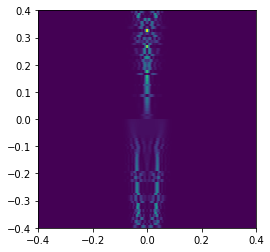

In [14]:
plt.figure()
Spectrum = np.zeros(a_sweep.shape)

for k in range(phi0.size):
    A = np.fft.fft(a_sweep[k,:])
    Spectrum[k,:] = np.abs(A)**2

plt.imshow(np.fft.fftshift(Spectrum), extent=(-0.4,0.4,-0.4,0.4))